In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import shutil
from keras.layers import Input, Lambda, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras.optimizers import Adam
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
random.seed(7777)
#1. Give dataset path
data_dir = "/content/drive/MyDrive/Wang_521/Resized_Images_VGG16"

train_dir = '/content/drive/MyDrive/Wang_521/Dataset/train'
valid_dir = '/content/drive/MyDrive/Wang_521/Dataset/val'
test_dir = '/content/drive/MyDrive/Wang_521/Dataset/test'
split_ratio = (0.6, 0.2, 0.2)

In [ ]:
# Create the directories for train, valid, and test splits
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over the subdirectories in the data directory
for sub_dir in os.listdir(data_dir):
    sub_dir_path = os.path.join(data_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        # Create corresponding subdirectories in train, valid, and test splits
        train_sub_dir = os.path.join(train_dir, sub_dir)
        valid_sub_dir = os.path.join(valid_dir, sub_dir)
        test_sub_dir = os.path.join(test_dir, sub_dir)
        os.makedirs(train_sub_dir, exist_ok=True)
        os.makedirs(valid_sub_dir, exist_ok=True)
        os.makedirs(test_sub_dir, exist_ok=True)

        # Get the list of images in the current subdirectory
        images = os.listdir(sub_dir_path)
        random.shuffle(images)

        # Calculate the number of images for each split
        num_images = len(images)
        num_train = int(num_images * split_ratio[0])
        num_valid = int(num_images * split_ratio[1])
        num_test = num_images - num_train - num_valid

        # Split the images into train, valid, and test sets
        train_images = images[:num_train]
        valid_images = images[num_train:num_train+num_valid]
        test_images = images[num_train+num_valid:]

        # Move the images to the corresponding directories
        for image in train_images:
            src = os.path.join(sub_dir_path, image)
            dst = os.path.join(train_sub_dir, image)
            shutil.copyfile(src, dst)

        for image in valid_images:
            src = os.path.join(sub_dir_path, image)
            dst = os.path.join(valid_sub_dir, image)
            shutil.copyfile(src, dst)

        for image in test_images:
            src = os.path.join(sub_dir_path, image)
            dst = os.path.join(test_sub_dir, image)
            shutil.copyfile(src, dst)

In [ ]:
batch_size = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    seed=7777
)
# Validation data generator
valid_generator = train_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    seed=7777
)
# Test data generator
test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    seed=7777
)

Found 4687 images belonging to 3 classes.
Found 1562 images belonging to 3 classes.
Found 1564 images belonging to 3 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer, fine_tune=0):

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

optimizer=adam

In [ ]:
input_shape = (224, 224, 3)
n_classes=3

n_steps = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size

In [ ]:
input_shape = (224, 224, 3)
n_classes=3

#set the optimizer use adam
optim_adam = Adam()

# First we'll train the model without Fine-tuning using default Adam
vgg_model_adam = create_model(input_shape, n_classes, optim_adam, fine_tune=0)

# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model_adam.layers):
  print(i, layer.name, layer.trainable)

58889256/58889256 [==============================] - 1s 0us/step
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
19 flatten True
20 dense True
21 dense_1 True
22 dropout True
23 dense_2 True


In [ ]:
vgg_model_adam.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
n_steps = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size

In [ ]:
vgg_history_adam = vgg_model_adam.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 1452s 10s/step - loss: 8.1572 - accuracy: 0.9160 - val_loss: 0.1255 - val_accuracy: 0.9811


In [ ]:
# Evaluate the model on the test set
test_loss_adam, test_acc_adam = vgg_model_adam.evaluate(test_generator)
print('Adam Test Loss :', test_loss_adam)
print('Adam Test accuracy:', test_acc_adam)

49/49 [==============================] - 353s 7s/step - loss: 0.2213 - accuracy: 0.9783
Adam Test Loss : 0.2213444858789444
Adam Test accuracy: 0.97826087474823


1.2 optimizr=sgd

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

from keras.optimizers import SGD

#set the optimizer use SGD
optim_sgd = SGD()

# First we'll train the model without Fine-tuning using default SGD
vgg_model_sgd = create_model(input_shape, n_classes, optim_sgd, fine_tune=0)

In [ ]:
vgg_history_sgd = vgg_model_sgd.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 117s 797ms/step - loss: nan - accuracy: 0.3368 - val_loss: nan - val_accuracy: 0.3333


In [ ]:
# Evaluate the model on the test set
test_loss_sgd, test_acc_sgd = vgg_model_sgd.evaluate(test_generator)
print('SGD Test Loss:', test_loss_sgd)
print('SGD Test accuracy:', test_acc_sgd)

49/49 [==============================] - 25s 514ms/step - loss: nan - accuracy: 0.3325
SGD Test Loss: nan
SGD Test accuracy: 0.3324808180332184


1.3 optimizer is RMSprop

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

from keras.optimizers import RMSprop

#set the optimizer use SGD
optim_RMSprop = RMSprop()

# First we'll train the model without Fine-tuning using default Adam
vgg_model_RMSprop = create_model(input_shape, n_classes, optim_RMSprop, fine_tune=0)

In [ ]:
vgg_history_RMSprop = vgg_model_RMSprop.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 120s 821ms/step - loss: 27.7341 - accuracy: 0.9042 - val_loss: 0.1913 - val_accuracy: 0.9798


In [ ]:
# Evaluate the model on the test set
test_loss_RMSprop, test_acc_RMSprop = vgg_model_RMSprop.evaluate(test_generator)
print('RMSprop Test Loss:', test_loss_RMSprop)
print('RMSprop Test accuracy:', test_acc_RMSprop)

49/49 [==============================] - 24s 483ms/step - loss: 0.2273 - accuracy: 0.9795
RMSprop Test Loss: 0.22726868093013763
RMSprop Test accuracy: 0.9795396327972412


1.4 optimizer is Adadelta

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

from keras.optimizers import Adadelta

#set the optimizer use SGD
optim_Adadelta = Adadelta()

# First we'll train the model without Fine-tuning using default Adam
vgg_model_Adadelta = create_model(input_shape, n_classes, optim_Adadelta, fine_tune=0)

In [ ]:
vgg_history_Adadelta = vgg_model_Adadelta.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 115s 784ms/step - loss: 2.8994 - accuracy: 0.5873 - val_loss: 0.9098 - val_accuracy: 0.8014


In [ ]:
# Evaluate the model on the test set
test_loss_Adadelta, test_acc_Adadelta = vgg_model_Adadelta.evaluate(test_generator)
print('Adadelta Test Loss:', test_loss_Adadelta)
print('Adadelta Test accuracy:', test_acc_Adadelta)

49/49 [==============================] - 22s 451ms/step - loss: 1.0000 - accuracy: 0.8075
Adadelta Test Loss: 0.9999516606330872
Adadelta Test accuracy: 0.8075447678565979


1.5 optimizer is Adagrad

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

from keras.optimizers import Adagrad

#set the optimizer use SGD
optim_Adagrad = Adagrad()

# First we'll train the model without Fine-tuning using default Adam
vgg_model_Adagrad = create_model(input_shape, n_classes, optim_Adagrad, fine_tune=0)

In [ ]:
vgg_history_Adagrad = vgg_model_Adagrad.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 114s 777ms/step - loss: 1.6454 - accuracy: 0.9205 - val_loss: 0.0931 - val_accuracy: 0.9792


In [ ]:
# Evaluate the model on the test set
test_loss_Adagrad, test_acc_Adagrad = vgg_model_Adagrad.evaluate(test_generator)
print('Adadelta Test Loss:', test_loss_Adagrad)
print('Adadelta Test accuracy:', test_acc_Adagrad)

49/49 [==============================] - 24s 483ms/step - loss: 0.1260 - accuracy: 0.9738
Adadelta Test Loss: 0.12599189579486847
Adadelta Test accuracy: 0.9737851619720459


1.6 optimizer is Adamax

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

from keras.optimizers import Adamax

#set the optimizer use SGD
optim_Adamax = Adamax()

# First we'll train the model without Fine-tuning using default Adam
vgg_model_Adamax = create_model(input_shape, n_classes, optim_Adamax, fine_tune=0)

In [ ]:
vgg_history_Adamax = vgg_model_Adamax.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 117s 799ms/step - loss: 9.7801 - accuracy: 0.9070 - val_loss: 0.1185 - val_accuracy: 0.9779


In [ ]:
# Evaluate the model on the test set
test_loss_Adamax, test_acc_Adamax = vgg_model_Adamax.evaluate(test_generator)
print('Adadelta Test Loss:', test_loss_Adamax)
print('Adadelta Test accuracy:', test_acc_Adamax)

49/49 [==============================] - 24s 487ms/step - loss: 0.0935 - accuracy: 0.9840
Adadelta Test Loss: 0.09346838295459747
Adadelta Test accuracy: 0.9840153455734253


1.7 optimizer is Nadam

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

from keras.optimizers import Nadam

#set the optimizer use SGD
optim_Nadam = Nadam()

# First we'll train the model without Fine-tuning using default Adam
vgg_model_Nadam = create_model(input_shape, n_classes, optim_Nadam, fine_tune=0)

In [ ]:
vgg_history_Nadam = vgg_model_Nadam.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 101s 682ms/step - loss: 6.1001 - accuracy: 0.9280 - val_loss: 0.5594 - val_accuracy: 0.9010


In [ ]:
# Evaluate the model on the test set
test_loss_Nadam, test_acc_Nadam = vgg_model_Nadam.evaluate(test_generator)
print('Adadelta Test Loss:', test_loss_Nadam)
print('Adadelta Test accuracy:', test_acc_Nadam)

49/49 [==============================] - 23s 464ms/step - loss: 0.4576 - accuracy: 0.9156
Adadelta Test Loss: 0.4576485753059387
Adadelta Test accuracy: 0.9156010150909424


2.1 Adam: learning rate=0.1

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

#set the optimizer use adam
optim_Adamax = Adamax(learning_rate=0.1)

# First we'll train the model without Fine-tuning using Adam
vgg_model_Adamax = create_model(input_shape, n_classes, optim_Adamax, fine_tune=0)

In [ ]:
vgg_history_Adamax = vgg_model_Adamax.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 128s 875ms/step - loss: 77441.8203 - accuracy: 0.8919 - val_loss: 65.3335 - val_accuracy: 0.9701


In [ ]:
# Evaluate the model on the test set
test_loss_Adamax, test_acc_Adamax = vgg_model_Adamax.evaluate(test_generator)
print('Adamax Test Loss(lr=0.1) :', test_loss_Adamax)
print('Adamax Test accuracy(lr=0.1):', test_acc_Adamax)

49/49 [==============================] - 24s 492ms/step - loss: 214.1566 - accuracy: 0.9629
Adamax Test Loss(lr=0.1) : 214.15655517578125
Adamax Test accuracy(lr=0.1): 0.9629155993461609


2.2 Adam: learning rate=0.01

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

#set the optimizer use adam
optim_Adamax_2 = Adamax(learning_rate=0.01)

# First we'll train the model without Fine-tuning using Adam
vgg_model_Adamax_2 = create_model(input_shape, n_classes, optim_Adamax_2, fine_tune=0)

In [ ]:
vgg_history_Adamax_2 = vgg_model_Adamax_2.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 117s 800ms/step - loss: 253.2394 - accuracy: 0.9182 - val_loss: 3.0161 - val_accuracy: 0.9557


In [ ]:
# Evaluate the model on the test set
test_loss_Adamax_2, test_acc_Adamax_2 = vgg_model_Adamax_2.evaluate(test_generator)
print('Adamax Test Loss(lr=0.01) :', test_loss_Adamax_2)
print('Adamax Test accuracy(lr=0.01):', test_acc_Adamax_2)

49/49 [==============================] - 24s 491ms/step - loss: 3.4038 - accuracy: 0.9482
Adamax Test Loss(lr=0.01) : 3.403779983520508
Adamax Test accuracy(lr=0.01): 0.9482097029685974


2.3 Adam: learning rate=0.001

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

#set the optimizer use adam
optim_Adamax_3 = Adamax(learning_rate=0.001)

# First we'll train the model without Fine-tuning using Adam
vgg_model_Adamax_3 = create_model(input_shape, n_classes, optim_Adamax_3, fine_tune=0)

In [ ]:
vgg_history_Adamax_3 = vgg_model_Adamax_3.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 134s 913ms/step - loss: 7.2606 - accuracy: 0.9222 - val_loss: 0.1112 - val_accuracy: 0.9857


In [ ]:
# Evaluate the model on the test set
test_loss_Adamax_3, test_acc_Adamax_3 = vgg_model_Adamax_3.evaluate(test_generator)
print('Adamax Test Loss(lr=0.01) :', test_loss_Adamax_3)
print('Adamax Test accuracy(lr=0.01):', test_acc_Adamax_3)

49/49 [==============================] - 25s 510ms/step - loss: 0.1699 - accuracy: 0.9808
Adamax Test Loss(lr=0.01) : 0.16993825137615204
Adamax Test accuracy(lr=0.01): 0.9808183908462524


2.4 Adam: learning rate=0.0001

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

from keras.optimizers import Adamax
#set the optimizer use adam
optim_Adamax_4 = Adamax(learning_rate=0.0001)

# First we'll train the model without Fine-tuning using Adam
vgg_model_Adamax_4 = create_model(input_shape, n_classes, optim_Adamax_4, fine_tune=0)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg_history_Adamax_4 = vgg_model_Adamax_4.fit(train_generator,
                            batch_size=batch_size,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            verbose=1)

146/146 [==============================] - 1139s 8s/step - loss: 0.9080 - accuracy: 0.9291 - val_loss: 0.1994 - val_accuracy: 0.9753


In [ ]:
# Evaluate the model on the test set
test_loss_Adamax_4, test_acc_Adamax_4 = vgg_model_Adamax_4.evaluate(test_generator)
print('Adamax Test Loss(lr=0.0001) :', test_loss_Adamax_4)
print('Adamax Test accuracy(lr=0.0001):', test_acc_Adamax_4)

49/49 [==============================] - 367s 8s/step - loss: 0.3071 - accuracy: 0.9680
Adamax Test Loss(lr=0.0001) : 0.3071066737174988
Adamax Test accuracy(lr=0.0001): 0.9680306911468506


3.1 Adam, learning_rate=0.001, epoch=5

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

from keras.callbacks import ModelCheckpoint
# ModelCheckpoint callback - save best weights
t4_checkpoint_1 = ModelCheckpoint(filepath='t4_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

optim = Adamax(learning_rate=0.001)

n_epochs = 5

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim, fine_tune=0)

In [ ]:
vgg_history_1 = vgg_model.fit(train_generator,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[t4_checkpoint_1],
                            verbose=1)

Epoch 1/5
146/146 [==============================] - ETA: 0s - loss: 7.4181 - accuracy: 0.9173
Epoch 1: val_loss improved from inf to 0.24118, saving model to t4_model_v1.weights.best.hdf5
146/146 [==============================] - 118s 806ms/step - loss: 7.4181 - accuracy: 0.9173 - val_loss: 0.2412 - val_accuracy: 0.9772
Epoch 2/5
146/146 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9770
Epoch 2: val_loss improved from 0.24118 to 0.12248, saving model to t4_model_v1.weights.best.hdf5
146/146 [==============================] - 112s 765ms/step - loss: 0.2048 - accuracy: 0.9770 - val_loss: 0.1225 - val_accuracy: 0.9876
Epoch 3/5
146/146 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.9822
Epoch 3: val_loss improved from 0.12248 to 0.06317, saving model to t4_model_v1.weights.best.hdf5
146/146 [==============================] - 129s 875ms/step - loss: 0.1104 - accuracy: 0.9822 - val_loss: 0.0632 - val_accuracy: 0.9876
Epoch 4/5
146/146 [=

Text(0.5, 0, 'Epochs')

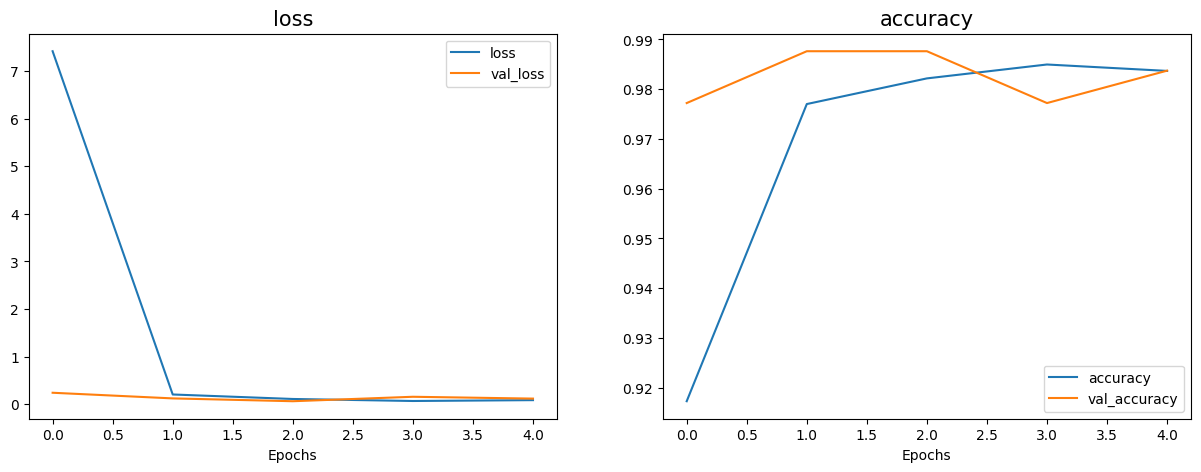

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot learning curve

ax[0].plot(vgg_history_1.history['loss'])
ax[0].plot(vgg_history_1.history['val_loss'])
ax[0].legend(['loss','val_loss'], prop={'size': 10});
ax[0].set_title('loss', fontsize=15)
ax[0].set_xlabel('Epochs')

# Plot learning curve
ax[1].plot(vgg_history_1.history['accuracy'])
ax[1].plot(vgg_history_1.history['val_accuracy'])
ax[1].legend(['accuracy','val_accuracy'],prop={'size': 10});
ax[1].set_title('accuracy', fontsize=15)
ax[1].set_xlabel('Epochs')

In [ ]:
# Generate predictions
vgg_model.load_weights('t4_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

49/49 [==============================] - 24s 483ms/step


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = vgg_model.evaluate(test_generator)
print('Adamax Test Loss :', test_loss)
print('Adamax Test accuracy:', test_acc)

49/49 [==============================] - 22s 451ms/step - loss: 0.0808 - accuracy: 0.9847
Adamax Test Loss : 0.08083156496286392
Adamax Test accuracy: 0.9846547245979309


3.2 epoch=10

In [ ]:
# ModelCheckpoint callback - save best weights
t7_checkpoint_1 = ModelCheckpoint(filepath='t7_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

n_epochs = 10

optim = Adamax(learning_rate=0.001)

# First we'll train the model without Fine-tuning
vgg_model_2 = create_model(input_shape, n_classes, optim, fine_tune=0)

In [ ]:
vgg_history_2 = vgg_model_2.fit(train_generator,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[t7_checkpoint_1],
                            verbose=1)

Epoch 1/10
146/146 [==============================] - ETA: 0s - loss: 10.2355 - accuracy: 0.9145
Epoch 1: val_loss improved from inf to 0.15811, saving model to t7_model_v1.weights.best.hdf5
146/146 [==============================] - 125s 854ms/step - loss: 10.2355 - accuracy: 0.9145 - val_loss: 0.1581 - val_accuracy: 0.9753
Epoch 2/10
146/146 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9751
Epoch 2: val_loss improved from 0.15811 to 0.10385, saving model to t7_model_v1.weights.best.hdf5
146/146 [==============================] - 123s 842ms/step - loss: 0.1603 - accuracy: 0.9751 - val_loss: 0.1039 - val_accuracy: 0.9818
Epoch 3/10
146/146 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9809
Epoch 3: val_loss improved from 0.10385 to 0.03379, saving model to t7_model_v1.weights.best.hdf5
146/146 [==============================] - 107s 734ms/step - loss: 0.0789 - accuracy: 0.9809 - val_loss: 0.0338 - val_accuracy: 0.9889
Epoch 4/10
146/

Text(0.5, 0, 'Epochs')

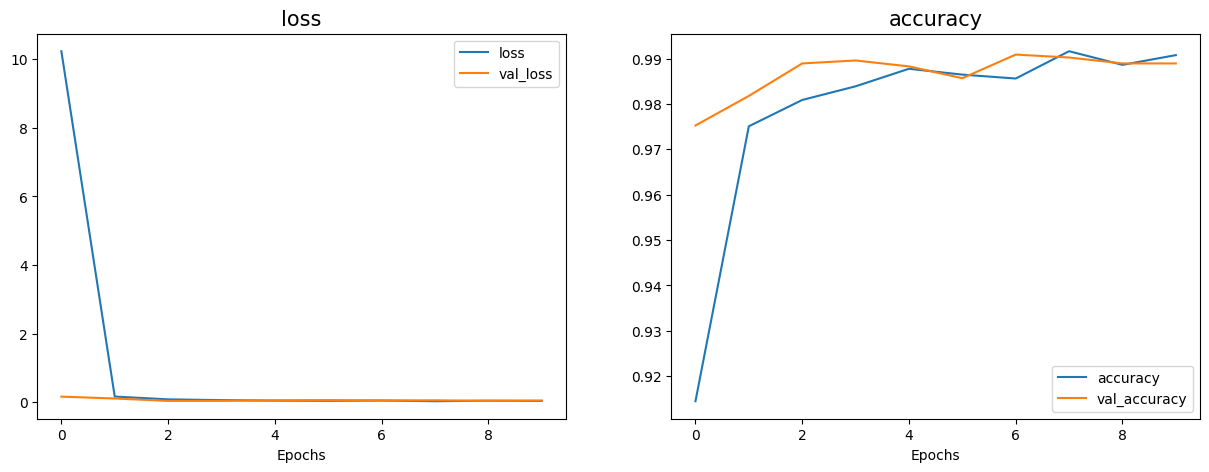

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot learning curve

ax[0].plot(vgg_history_2.history['loss'])
ax[0].plot(vgg_history_2.history['val_loss'])
ax[0].legend(['loss','val_loss'], prop={'size': 10});
ax[0].set_title('loss', fontsize=15)
ax[0].set_xlabel('Epochs')

# Plot learning curve
ax[1].plot(vgg_history_2.history['accuracy'])
ax[1].plot(vgg_history_2.history['val_accuracy'])
ax[1].legend(['accuracy','val_accuracy'],prop={'size': 10});
ax[1].set_title('accuracy', fontsize=15)
ax[1].set_xlabel('Epochs')

In [ ]:
# initialize the best trained weights
vgg_model.load_weights('t7_model_v1.weights.best.hdf5')

vgg_preds_2 = vgg_model.predict(test_generator)
vgg_pred_classes_2 = np.argmax(vgg_preds_2, axis=1)

49/49 [==============================] - 26s 524ms/step


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = vgg_model.evaluate(test_generator)
print('Adamax Test Loss :', test_loss)
print('Adamax Test accuracy:', test_acc)

49/49 [==============================] - 24s 484ms/step - loss: 0.0669 - accuracy: 0.9808
Adamax Test Loss : 0.0669456273317337
Adamax Test accuracy: 0.9808183908462524


3.3 epoch=20

In [ ]:
# ModelCheckpoint callback - save best weights
t3_checkpoint_1 = ModelCheckpoint(filepath='t3_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

n_epochs = 20

optim = Adamax(learning_rate=0.001)

# First we'll train the model without Fine-tuning
vgg_model_3 = create_model(input_shape, n_classes, optim, fine_tune=0)

In [ ]:
vgg_history_3 = vgg_model_3.fit(train_generator,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[t3_checkpoint_1],
                            verbose=1)

Epoch 1/20
146/146 [==============================] - ETA: 0s - loss: 1.5867 - accuracy: 0.9351
Epoch 1: val_loss improved from inf to 1.15049, saving model to t3_model_v1.weights.best.hdf5
146/146 [==============================] - 130s 886ms/step - loss: 1.5867 - accuracy: 0.9351 - val_loss: 1.1505 - val_accuracy: 0.9466
Epoch 2/20
146/146 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.9734
Epoch 2: val_loss improved from 1.15049 to 0.20257, saving model to t3_model_v1.weights.best.hdf5
146/146 [==============================] - 134s 920ms/step - loss: 0.5401 - accuracy: 0.9734 - val_loss: 0.2026 - val_accuracy: 0.9818
Epoch 3/20
146/146 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9813
Epoch 3: val_loss did not improve from 0.20257
146/146 [==============================] - 127s 871ms/step - loss: 0.2475 - accuracy: 0.9813 - val_loss: 0.2401 - val_accuracy: 0.9785
Epoch 4/20
146/146 [==============================] - ETA: 0s - loss

Text(0.5, 0, 'Epochs')

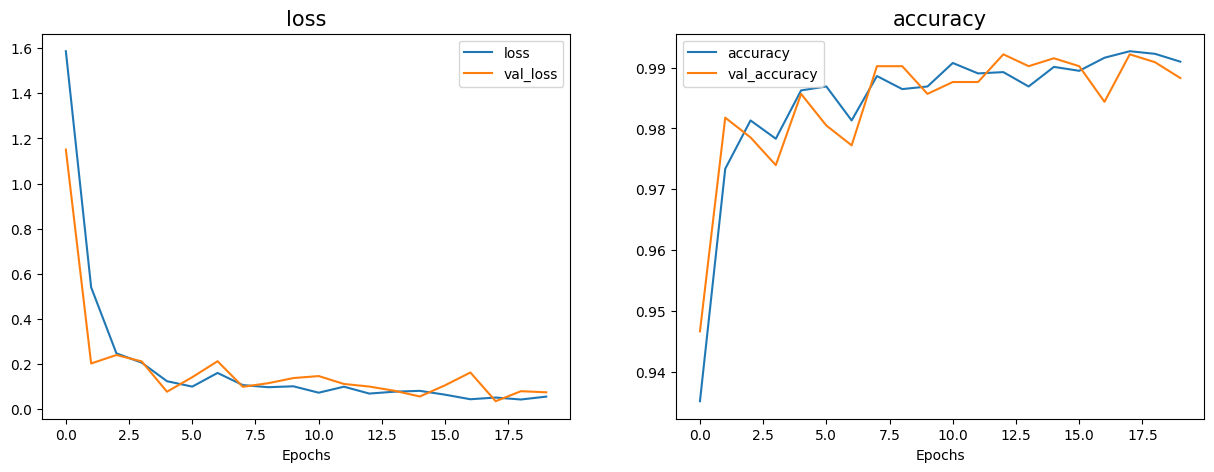

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot learning curve

ax[0].plot(vgg_history_3.history['loss'])
ax[0].plot(vgg_history_3.history['val_loss'])
ax[0].legend(['loss','val_loss'], prop={'size': 10});
ax[0].set_title('loss', fontsize=15)
ax[0].set_xlabel('Epochs')

# Plot learning curve
ax[1].plot(vgg_history_3.history['accuracy'])
ax[1].plot(vgg_history_3.history['val_accuracy'])
ax[1].legend(['accuracy','val_accuracy'],prop={'size': 10});
ax[1].set_title('accuracy', fontsize=15)
ax[1].set_xlabel('Epochs')

In [ ]:
# initialize the best trained weights
vgg_model_3.load_weights('t3_model_v1.weights.best.hdf5')

vgg_preds_3 = vgg_model_3.predict(test_generator)
vgg_pred_classes_3 = np.argmax(vgg_preds_3, axis=1)

49/49 [==============================] - 25s 513ms/step


In [ ]:
# Evaluate the model on the test set
test_loss_3, test_acc_3 = vgg_model_3.evaluate(test_generator)
print('Adamax Test Loss :', test_loss_3)
print('Adamax Test accuracy:', test_acc_3)

49/49 [==============================] - 24s 485ms/step - loss: 0.0478 - accuracy: 0.9891
Adamax Test Loss : 0.04775117710232735
Adamax Test accuracy: 0.989130437374115


# unfreeze last two layers (with epoch=5)

In [ ]:
# Reset our image data generators
train_generator.reset()
valid_generator.reset()
test_generator.reset()

n_epochs = 5
# Use a smaller learning rate
optim_2 = Adamax(learning_rate=0.001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

In [ ]:
vgg_history_ft = vgg_model_ft.fit(train_generator,
                            batch_size=batch_size,
                            epochs=n_epochs,
                            validation_data=valid_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[t4_checkpoint_1],
                            verbose=1)

Epoch 1/5
146/146 [==============================] - ETA: 0s - loss: 5.4513 - accuracy: 0.8851
Epoch 1: val_loss did not improve from 0.06317
146/146 [==============================] - 117s 797ms/step - loss: 5.4513 - accuracy: 0.8851 - val_loss: 0.1143 - val_accuracy: 0.9668
Epoch 2/5
146/146 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9785
Epoch 2: val_loss improved from 0.06317 to 0.04587, saving model to t4_model_v1.weights.best.hdf5
146/146 [==============================] - 122s 834ms/step - loss: 0.0642 - accuracy: 0.9785 - val_loss: 0.0459 - val_accuracy: 0.9896
Epoch 3/5
146/146 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9847
Epoch 3: val_loss did not improve from 0.04587
146/146 [==============================] - 117s 805ms/step - loss: 0.0546 - accuracy: 0.9847 - val_loss: 0.0472 - val_accuracy: 0.9837
Epoch 4/5
146/146 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9901
Epoch 4: val_loss did n

Text(0.5, 0, 'Epochs')

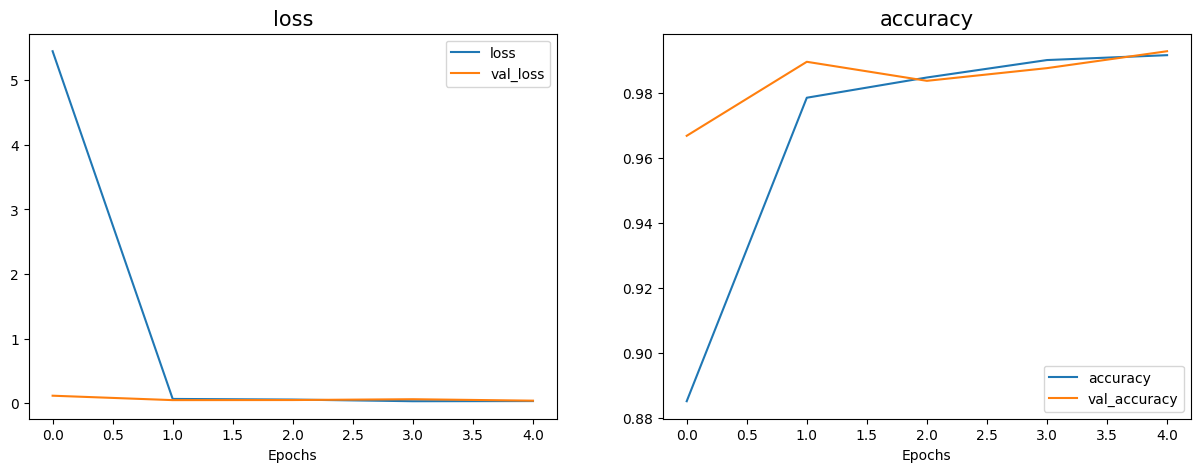

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot learning curve

ax[0].plot(vgg_history_ft.history['loss'])
ax[0].plot(vgg_history_ft.history['val_loss'])
ax[0].legend(['loss','val_loss'], prop={'size': 10});
ax[0].set_title('loss', fontsize=15)
ax[0].set_xlabel('Epochs')

# Plot learning curve
ax[1].plot(vgg_history_ft.history['accuracy'])
ax[1].plot(vgg_history_ft.history['val_accuracy'])
ax[1].legend(['accuracy','val_accuracy'],prop={'size': 10});
ax[1].set_title('accuracy', fontsize=15)
ax[1].set_xlabel('Epochs')

In [ ]:
# initialize the best trained weights
vgg_model.load_weights('t4_model_v1.weights.best.hdf5')

vgg_preds_ft = vgg_model_ft.predict(test_generator)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

49/49 [==============================] - 27s 541ms/step


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = vgg_model.evaluate(test_generator)
print('Adamax Test Loss :', test_loss)
print('Adamax Test accuracy:', test_acc)

49/49 [==============================] - 23s 475ms/step - loss: 0.0352 - accuracy: 0.9879
Adamax Test Loss : 0.03515332564711571
Adamax Test accuracy: 0.9878516793251038


# comparison (epoch=5)

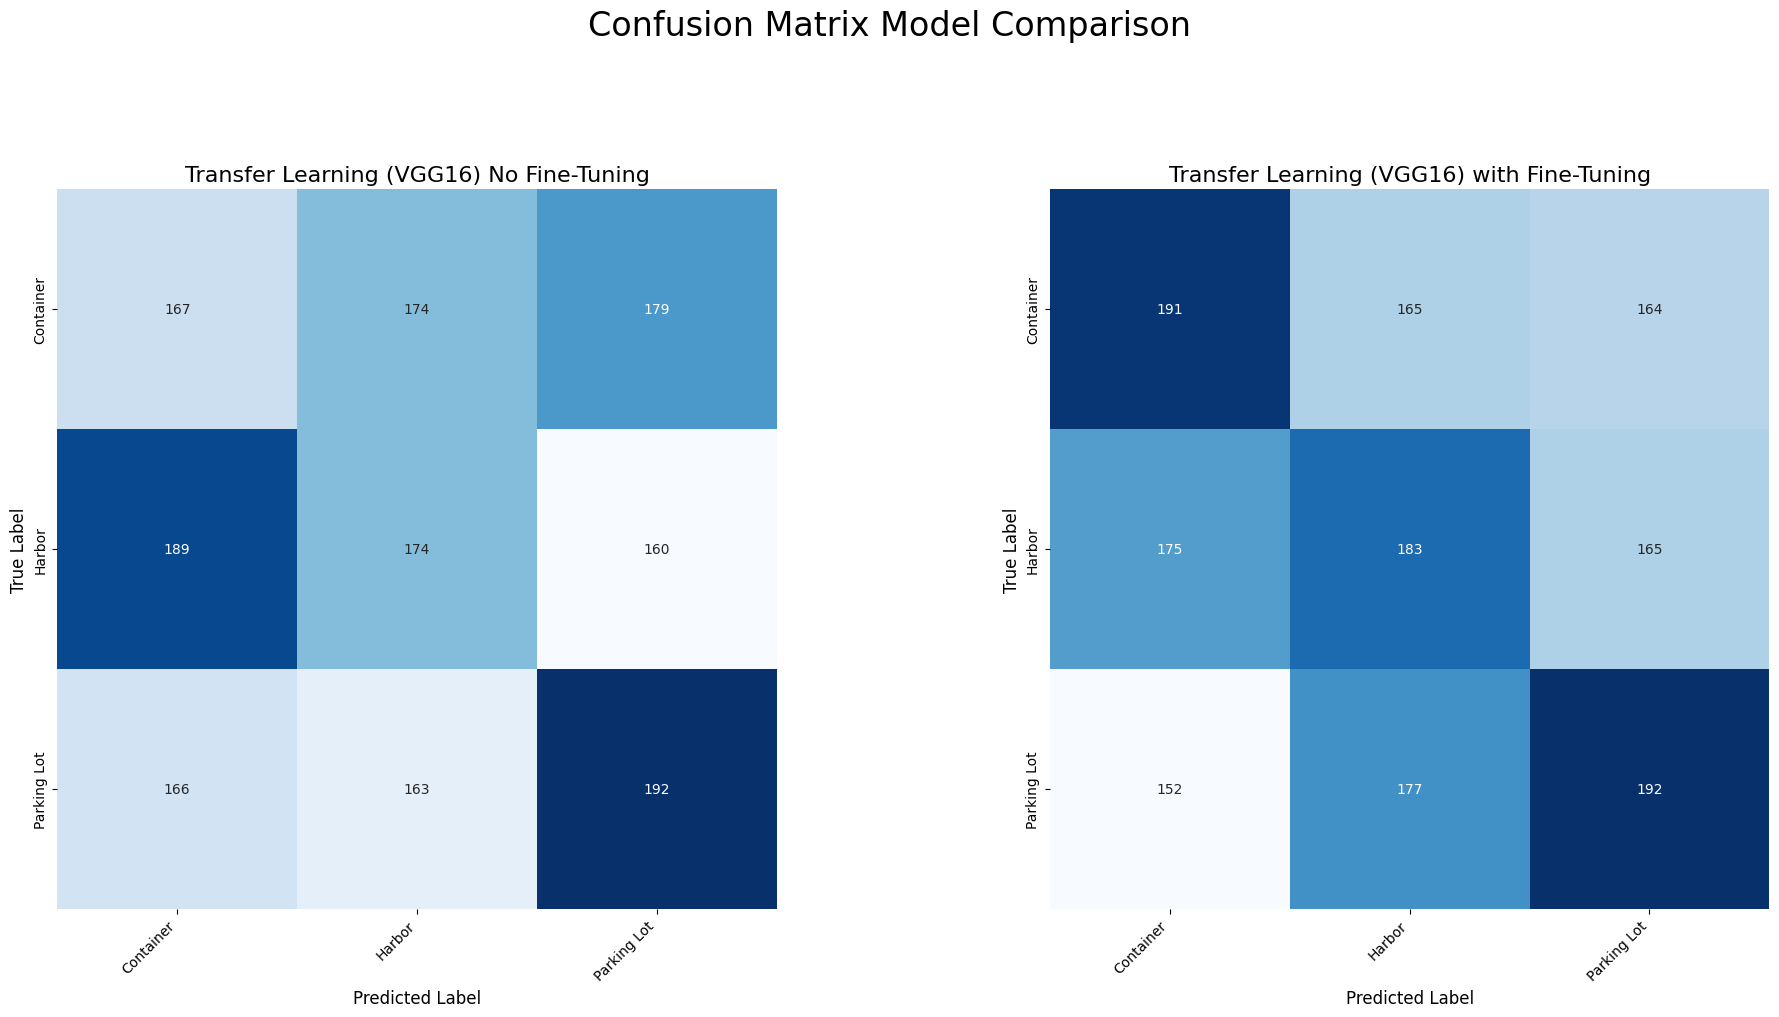

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(20, 10))

# plot_heatmap(true_classes, scratch_pred_classes, class_names, ax1, title="Custom CNN")
# 修改这里的vgg_pred_classes,
plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")
plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.show()